# ASR Lab 2 - Computing HMM probabilities

To begin with, we'll use your function to generate a Word WFST for the word "*peppers*", using `generate_word_wfst('peppers')`.  By viewing this as an HMM, you'll be able to sample possible paths through the model and also generate the likelihood of an observation sequence $(x_1, \dotsc, x_T)$.

We'll build on this to implement the basics of the Viterbi algorithm, which can later be used for word recognition.

First, copy your code from Lab 1 into the space below.  You can use the official solutions if you like.
If you want to extract the code-only parts of your previous notebook, on the terminal command line you can type:

```bash
jupyter nbconvert --to python <notebook-name.ipynb>
```

where <notebook-name.ipynb> indicates the path of the notebook file.

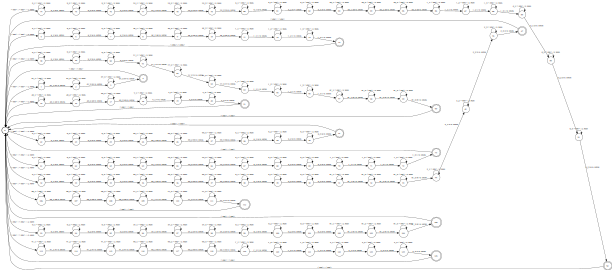

In [1]:
#!/usr/bin/env python
# coding: utf-8

# We start by importing the OpenFst Python wrapper:

# In[1]:


import openfst_python as fst
import math
partner = "s1922482"            # Minghui Zhao


# Then we create tables for our symbols

# In[2]:


input_sym = fst.SymbolTable()
output_sym = fst.SymbolTable()

input_sym.add_symbol('<eps>') # by convention, <eps> always
                              # has symbol zero
input_sym.add_symbol('a')  # input symbols
input_sym.add_symbol('b')

output_sym.add_symbol('<eps>')  # output symbols
output_sym.add_symbol('d')
output_sym.add_symbol('c')


# A **SymbolTable()** is simply a table associating symbols and indexes. We add symbols to the table with the method **add_symbol()**
# 
# Now that we've got our symbol tables, we will build the FST itself:

# In[3]:


f = fst.Fst()

f.set_input_symbols(input_sym)
f.set_output_symbols(output_sym)


# Our FST transduces the input to the outputs, so we set the symbol tables as such. Now, we want to add a number of states:

# In[4]:


s0 = f.add_state()
s1 = f.add_state()
s2 = f.add_state()
s3 = f.add_state()


# The output of the **add_state()** method is just the index assigned to the state, but it can be useful to assign that index to a variable to give it a more meaningful label.
# 
# To create arcs between states, we do:

# In[5]:


a = input_sym.find('a')
b = input_sym.find('b')
c = output_sym.find('c')
d = output_sym.find('d')

f.add_arc(s0, fst.Arc(a, c, None, s1))
f.add_arc(s0, fst.Arc(b, d, None, s2))
f.add_arc(s1, fst.Arc(a, c, None, s3))
f.add_arc(s2, fst.Arc(b, d, None, s3))


# The syntax for the method **add_arc** is:
# 
# **add_arc(*source state*, *arc to add*)**
# 
# while the syntax for initializing a class **Arc()** is:
# 
# **Arc(*input symbol index*, *output symbol index*, *weight*, *destination state*)**
# 
# We use the **find()** method of the symbol tables to get the index of a certain label.
# 
# Now we just add start and end states:

# In[6]:


f.set_start(s0)
f.set_final(s3)


# And voila, our first FST, shown in the example above, is done!

# # Exercises

# In[7]:


def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex


# In[8]:


lex = parse_lexicon('lexicon.txt')
lex


# 1. Write a function that generates symbol tables from a lexicon, using the provided phonetic dictionary in **lexicon.txt** and the helper function *parse_lexicon* in cells above. Use p_1, p_2, ..., eh_1, ... to denote the phone states. 

# In[9]:


def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    state_table.add_symbol('<eps>') 
    phone_table.add_symbol('<eps>') 
    word_table.add_symbol('<eps>') 
    
    for word, phones in lexicon.items():
        word_table.add_symbol(word)
        for phone in phones:
            phone_table.add_symbol(phone)
            for i in range(1, n+1):
                state_table.add_symbol('{}_{}'.format(phone,i))

    return word_table, phone_table, state_table


# In[10]:


word_table, phone_table, state_table = generate_symbol_tables(lex)


# 2. Create functions generating WFSTs representing the following HMMs:
# 
#     1. A 3-state left-to-right phone HMM with self-loops
#     2. A parallel-path left-to-right model (shown on Slide 10 of Lecture 4)
#     3. An ergodic HMM with $n$ states (you will need to think about how to handle final states)

# In[11]:


def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    out_label = phone_table.find(phone)
    
    for i in range(1, n+1):
        in_label = state_table.find('{}_{}'.format(phone, i))
        weight = fst.Weight('log', -math.log(0.1))
        f.add_arc(current_state, fst.Arc(in_label, 0, weight, current_state))
        new_state = f.add_state()
        weight = fst.Weight('log', -math.log(0.9))
        f.add_arc(current_state, fst.Arc(in_label, out_label, weight, new_state))
        current_state = new_state
    
    return current_state

f = fst.Fst('log')
start = f.add_state()
f.set_start(start)

last_state = generate_phone_wfst(f, start, 'p', 3)

f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)


# In[12]:


def generate_parallel_path_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state parallel-path left-to-right HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    current_state = start_state
   
    for i in range(n):
        f.add_arc(current_state, fst.Arc(0, 0, None, current_state))
        if current_state-2 >= 0:
            f.add_arc(current_state-2, fst.Arc(0, 0, None, current_state))
        new_state = f.add_state()
        f.add_arc(current_state, fst.Arc(0, 0, None, new_state))
        current_state = new_state
    f.add_arc(current_state-2, fst.Arc(0, 0, None, current_state))
#     f.set_final(current_state)
   
    return current_state


f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_parallel_path_wfst(f, start, 4)
f


# In[13]:


def generate_ergodic_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state ergodic HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """    
    
    current_state = start_state
    
    for i in range(n):
        new_state = f.add_state()
    
    for i in range(n):
        for j in range(n+1):
            f.add_arc(i, fst.Arc(0, 0, None, j))

    return current_state


f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_ergodic_wfst(f, start, 5)
f


# 3. Write a function to generate an HMM for any word in the lexicon using $n$ states per phone by concatenating $n$-state phone HMMs. Make use of your *generate_phone_wfst()* function. 

# In[14]:


def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output word labels.
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """

    current_state = start_state
    
    phones = lex[word]
    for phone in phones:
        current_state = generate_phone_wfst(f, current_state, phone, n)
    
    f.set_final(current_state)
    
    return f

f = fst.Fst('log')
start = f.add_state()
f.set_start(start)

generate_word_wfst(f, start, 'peppers', 3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)


# 4. Generate an HMM that can recognise:
# 
#     1. any phone contained in the lexicon
#     2. any sequence of phones contained in the lexicon
#     
# Think of the difference between the first and the second HMM. Again, previous functions should help in the task. 

# In[15]:


def generate_phone_recognition_wfst(n):
    """ generate a HMM to recognise any single phone in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    final_state = f.add_state()
    f.set_final(final_state)
    for i, phone in phone_table:
        if phone != '<eps>':
            tmp_state = f.add_state()
            weight = fst.Weight('log', -math.log(phone_table.num_symbols()))
            f.add_arc(start_state, fst.Arc(0, 0, weight, tmp_state))
            last_state = generate_phone_wfst(f, tmp_state, phone, n)
            # f.set_final(last_state)
            weight = fst.Weight('log', -math.log(1))
            f.add_arc(last_state, fst.Arc(0, 0, weight, final_state))
            
    return f

f = generate_phone_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)


# In[18]:


def generate_phone_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single phone sequence in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    for i, phone in phone_table:
        if phone != '<eps>':
            tmp_state = f.add_state()
            weight = fst.Weight('log', -math.log(phone_table.num_symbols()))
            f.add_arc(start_state, fst.Arc(0, 0, weight, tmp_state))
            last_state = generate_phone_wfst(f, tmp_state, phone, n)
            f.set_final(last_state)
            weight = fst.Weight('log', -math.log(1))
            f.add_arc(last_state, fst.Arc(0, 0, weight, start_state))
            
    return f

f = generate_phone_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)
f


# 5. You have decided that the best way to start teaching a friend English is to have them learn the notorious tongue-twister *peter piper picked a peck of pickled peppers*.  Write a function that creates an HMM that can recognize any sequence of these words.

# In[22]:


def generate_word_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    for _, word in word_table:
        if word != '<eps>':
            tmp_state = f.add_state()
            weight = fst.Weight('log', -math.log(word_table.num_symbols()))
            f.add_arc(start_state, fst.Arc(0, 0, weight, tmp_state))
            word_wfst = generate_word_wfst(f, tmp_state, word, n)
            weight = fst.Weight('log', -math.log(1.0))
            f.add_arc(list(word_wfst.states())[-1], fst.Arc(0, 0, weight, start_state))
        
    return f

f = generate_word_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)
f


# # If you have more time

# Probabilities in WFSTs are traditionally expressed in negative log format, that is, the weight $w$ on an arc transitioning between states $i$ and $j$ is given by $w=-\log a_{ij}$, where $a_{ij}$ is the HMM transition probability.
# 
# 6. Add weights to your WFSTs corresponding to transition probabilities.  Assume that the probability of a self-loop is $0.1$, and that when transitioning *between* separate phones or words, the probabilities are uniform over all transitions.

# In[ ]:






Now that the WFST has been constructed, we can traverse over the states and arcs.  This example (taken from [OpenFst](http://www.openfst.org/twiki/bin/view/FST/PythonExtension)) shows how you can do this:


In [2]:
for state in f.states():
    # iterate over all arcs leaving this state    
    for arc in f.arcs(state):
         print(state, arc.ilabel, arc.olabel, arc.weight, arc.nextstate)

0 0 0 -2.48490667 1
0 0 0 -2.48490667 5
0 0 0 -2.48490667 15
0 0 0 -2.48490667 22
0 0 0 -2.48490667 32
0 0 0 -2.48490667 48
0 0 0 -2.48490667 61
0 0 0 -2.48490667 74
0 0 0 -2.48490667 93
0 0 0 -2.48490667 106
0 0 0 -2.48490667 113
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
5 4 0 2.30258512 5
5 4 2 0.105360515 6
6 5 0 2.30258512 6
6 5 2 0.105360515 7
7 6 0 2.30258512 7
7 6 2 0.105360515 8
8 7 0 2.30258512 8
8 7 3 0.105360515 9
9 8 0 2.30258512 9
9 8 3 0.105360515 10
10 9 0 2.30258512 10
10 9 3 0.105360515 11
11 10 0 2.30258512 11
11 10 4 0.105360515 12
12 11 0 2.30258512 12
12 11 4 0.105360515 13
13 12 0 2.30258512 13
13 12 4 0.105360515 14
14 0 0 -0 0
15 13 0 2.30258512 15
15 13 5 0.105360515 16
16 14 0 2.30258512 16
16 14 5 0.105360515 17
17 15 0 2.30258512 17
17 15 5 0.105360515 18
18 16 0 2.30258512 18
18 16 6 0.105360515 19
19 17 0 2.30258512 19
19 17 6 0.105360515 20
20 18 0 2.30258512 20
20 18 6 

Alternatively, we could begin at the start state, and traverse in a depth-first manner.  **Warning**: the code below specifically handles self-loops, but won't work if your WFST has larger cycles in it!

In [3]:
def traverse_arcs(state):
    """Traverse every arc leaving a particular state
    """
    for arc in f.arcs(state):
        print(state, arc.ilabel, arc.olabel, arc.weight, arc.nextstate)
        
        if arc.nextstate != state:   # don't follow the self-loops or we'll get stuck forever!
            traverse_arcs(arc.nextstate)

s = f.start()
traverse_arcs(s)

0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.302585

4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3

4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3

3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2

2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1

1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0

3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2 1 0.105360515 3
3 3 0 2.30258512 3
3 3 1 0.105360515 4
4 0 0 -0 0
0 0 0 -2.48490667 1
1 1 0 2.30258512 1
1 1 1 0.105360515 2
2 2 0 2.30258512 2
2 2

RecursionError: maximum recursion depth exceeded while calling a Python object

For a more readable table, you could find the indexes of the input and output labels in your symbol tables and print the string instead.

## Exercises

1. Write code to randomly generate (sample) a path through your word HMM for "*peppers*".  You should output the sequence of input and output labels along the path.  To sample from a list of arcs, you can use code like

```python
import random

arc_list = list(f.arcs(state))
sampled_arc = random.sample(arc_list,1)[0]
```

  Notice that if you repeat your random sampling by running the code multiple times, you'll get paths of different lengths due to the self-loops


In [4]:
import random

def sample_random_path(f):
    '''Given an FST, randomly sample a path through it.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
        '''
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'): # the .final method returns the probability of a state being final
                                                                 # it's infinite when the state is NOT final
            arc_list = list(f.arcs(curr_state))
            sampled_arc = random.sample(arc_list, 1)[0]
            input_label_seq.append(sampled_arc.ilabel)
            output_label_seq.append(sampled_arc.olabel)
            
            curr_state = sampled_arc.nextstate
            
    return input_label_seq, output_label_seq

input_label_seq, output_label_seq = sample_random_path(f)

print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))

0 0
4 0
4 2
5 0
5 2
6 0
6 0
6 2
7 0
7 3
8 3
9 3
10 4
11 4
12 0
12 4


2. Now it's time to add probabilities to your WFST.  As mentioned at the end of Lab 1, probabilities in WFSTs are traditionally expressed in negative log format, that is, the weight $w$ on an arc transitioning between states $i$ and $j$ is given by $w=-\log a_{ij}$, where $a_{ij}$ is the HMM transition probability.  Remember that you can add weights using the third argument to `fst.Arc()`.

  You should now modify your code above to add weights to your word and phone recognition WFSTs from Lab 1, corresponding to transition probabilities.  Assume that the probability of a self-loop is $0.1$, and that when transitioning *between* separate multiple sets of phones (or words), the probabilities are uniform over all transitions.

  Remember to set your fst to use log probabilities and use log weights:

```python
import math
f = fst.Fst('log')

s1 = f.add_state()
s2 = f.add_state()
weight = fst.Weight('log', -math.log(0.1))
f.add_arc(s1, fst.Arc(0, 0, weight, s2))
```

3. Modify your answer to exercise 1 to sample a path through the word HMM *and* also compute the negative log probability of the path.  This gives you $-\log p(Q)$ in the lecture notation.  (Recall that $\log ab = \log a + \log b$)

  **Note**: Internally OpenFst stores weights in a special object that you will need to convert to a float, using the `float()` function, before adding your negative log probabilities.


In [7]:
import math
def sample_random_path_prob(f):
    '''Given an FST, randomly sample a path through it and compute the negative log probability.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
            neg_log_prob (float): negative log probability of the sampled path
        '''
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []
    neg_log_prob = 0.0

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'): # the .final method returns the probability of a state being final
                                                                 # it's infinite when the state is NOT final
            
            # your code here
            arc_list = list(f.arcs(curr_state))
            sampled_arc = random.sample(arc_list, 1)[0]
            input_label_seq.append(sampled_arc.ilabel)
            output_label_seq.append(sampled_arc.olabel)
            
            neg_log_prob += float(sampled_arc.weight)
            
            curr_state = sampled_arc.nextstate
            
    return input_label_seq, output_label_seq, -neg_log_prob

input_label_seq, output_label_seq, neg_log_prob = sample_random_path_prob(f)

print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))
print(neg_log_prob)

0 0
49 17
50 17
51 0
51 0
51 17
22 0
22 0
22 0
22 0
22 8
23 0
23 8
24 0
24 0
24 0
24 8
52 0
52 18
53 0
53 18
54 18
28 0
28 0
28 10
29 10
30 0
30 10
-33.318196310000005


4. You are now given a set of observations, ($x_1, \dotsc, x_t, \dotsc$).  Can you use your WFST for the word "*peppers*" to compute $p(X,Q)$ for a randomly sampled path $Q$ through the HMM?  For now, we won't use real samples $x_t$, and will instead assume that you already have a function `observation_probability(state, t)` that computes $b_j(t) = p(x_t|q_t=j)$, provided here:

In [ ]:
def observation_probability(hmm_label, t):
    """ Computes b_j(t) where j is the current state
    
    This is just a dummy version!  In later labs we'll generate 
    probabilities for real speech frames.
    
    You don't need to look at this function in detail.
    
    Args: hmm_label (str): the HMM state label, j.  We'll use string form: "p_1", "p_2", "eh_1" etc  
          t (int) : current time step, starting at 1
          
    Returns: 
          p (float): the observation probability p(x_t | q_t = hmm_label)
    """
    
    p = {} # dictionary of probabilities
    
    assert(t>0)
    
    # this is just a simulation!
    if t < 4:
        p = {'p_1': 1.0, 'p_2':1.0, 'p_3': 1.0, 'eh_1':0.2}
    elif t < 9:
        p = {'p_3': 0.5, 'eh_1':1.0, 'eh_2': 1.0, 'eh_3': 1.0}
    elif t < 13:
        p = {'eh_3': 1.0, 'p_1': 1.0, 'p_2': 1.0, 'p_3':1.0, 'er_1':0.5}
    elif t < 18:
        p = {'p_3': 1.0, 'er_1': 1.0, 'er_2': 1.0, 'er_3':0.7}
    elif t < 25:
        p = {'er_3': 1.0, 'z_1': 1.0, 'z_2': 1.0, 'z_3':1.0}
    else:
        p = {'z_2': 0.5, 'z_3': 1.0}
        
    for hmm_label in ['p_1', 'p_2', 'p_3', 'eh_1', 'eh_2', 'eh_3', 'er_1', 'er_2', 'er_3', 'z_1', 'z_2', 'z_3']:        
        if hmm_label not in p:
            p[hmm_label] = 0.01  # give all other states a small probability to avoid zero probability
            
    # normalise the probabilities:
    scale = sum(p.values())
    for k in p:
        p[k] = p[k]/scale
        
    return p[hmm_label]
    

Enter your code below.  You might want to convert the observation probabilities into negative log probabilities.


In [ ]:
def sample_random_path_obs_prob(f):
    '''Given an FST and observation probabilities, randomly sample a path
        through it and compute the negative log probability.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
            neg_log_prob (float): negative log probability of the sampled path
        '''
    t = 1
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []
    neg_log_prob = 0.0 # log(1) = 0

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'):
        # your code here
    
    
    return input_label_seq, output_label_seq, neg_log_prob

input_label_seq, output_label_seq, neg_log_prob = sample_random_path_obs_prob(f)
print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))
print(neg_log_prob)

You might have noticed that the dummy observation probability function above effectively allows the observation sequence $x_t$ to be arbitrarily long.  This is simply to allow it to match the length of your sampled path $Q$.  In real use, the observation sequence will have a fixed length $T$, and any matching path through the HMM will have to have the same length.  We'll explore this more when writing the Viterbi decoder in the next lab.

## If you have more time

You might like to start thinking about how to implement the Viterbi algorithm over HMMs in WFST form.  Try working with the "*peppers*" example above.  You'll need to write functions to compute and store the probabilities $V_j(t)$, giving the probability up to time step $t$ of the observation sequence $(x_1, \dotsc, x_t)$ along the most likely path $(q_1, \dotsc, q_t)$.